## GT대비 mediapipe complexity별 정확도

In [202]:
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import io

import glob
import pandas as pd

import cv2
import os
import re

gt로 사용할 데이터셋 시작과 끝 frame 2개 업로드
(이는, frame별로 json이 존재하여 합치기 위해 처리하는 과정)

In [203]:
# ground_truth 경로 설정
gt_base_path = './data/ground_truth/'
gt_json_path = ''  # 전역 변수
gt_json_name = []
# 디렉터리 내 모든 폴더명 수집 함수
def get_all_folders(path):
    try:
        folder_names = [
            name for name in os.listdir(path) 
            if os.path.isdir(os.path.join(path, name))
        ]
        print("Folders found in", path)
        return [os.path.join(path, folder) for folder in folder_names]
    except FileNotFoundError:
        print(f"The path '{path}' does not exist.")
        return []
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

# 업로드된 파일의 경로를 저장하는 함수
def store_gt_json_path(uploaded_files):
    global gt_json_path  # 전역 변수로 선언
    global gt_json_name
    for file_info in uploaded_files.values():
        filename = file_info['metadata']['name']  # 파일명 추출
        folders = get_all_folders(gt_base_path)  # 폴더 탐색
        gt_json_name.append(filename)

        for folder in folders:
            if filename in os.listdir(folder):
                gt_json_path = folder  # 경로 저장
                if len(gt_json_name) == 2 : 
                    print(f"gt_json_path set to: {gt_json_path}")
                    print(f"gt_json_name set to: {gt_json_name}")
                    return
    
# 업로드 이벤트 핸들러
def handle_file_upload(change):
    print("Upload complete. Processing...")
    store_gt_json_path(change['new'])

# 파일 업로드 위젯 생성
upload_widget = widgets.FileUpload(accept='.json', multiple=True)
upload_widget.observe(handle_file_upload, names='value')

# 위젯 표시
display(widgets.VBox([widgets.Label("Upload JSON files to search"), upload_widget]))

Upload complete. Processing...
Folders found in ./data/ground_truth/
Folders found in ./data/ground_truth/
gt_json_path set to: ./data/ground_truth/vid1
gt_json_name set to: ['20200615_General_005_DOS_P_F20_MM_003_3070.json', '20200615_General_005_DOS_P_F20_MM_003_3249.json']


frame별로 있는 json을 하나의 json으로 통합

In [204]:
# 경로 확인
print(f"gt_json_path: {gt_json_path}")

# 주어진 폴더 내 모든 JSON 파일 경로 가져오기
def get_json_files_from_folder(folder_path):
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON files found in {folder_path}")
    return json_files

# 첫 번째 JSON의 'categories.keypoints' 가져오기 함수
def get_keypoints_from_first_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data.get('categories', {}).get('keypoints', [])

# 모든 JSON의 'annotations.points'를 수집하고 frame으로 병합하는 함수
def collect_all_frames(json_files):
    frames = []
    for frame_idx, path in enumerate(json_files):
        with open(path, 'r') as f:
            data = json.load(f)
            annotations = data.get('annotations', [])
            for annotation in annotations:
                if 'points' in annotation:
                    frames.append({
                        "frame": frame_idx,
                        "points": annotation['points']
                    })
    return frames

# 통합된 JSON 생성 함수
def create_merged_json(keypoints, frames):
    merged_data = {
        "categories": {
            "keypoints": keypoints
        },
        "annotations": frames  # frames가 포함된 annotations
    }
    return merged_data

# 결과 JSON을 저장하는 함수
def save_merged_json(output_path, merged_data):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    with open(output_path, 'w') as f:
        json.dump(merged_data, f, indent=2)
    print(f"Merged JSON saved to {output_path}")

# 통합 프로세스 실행 함수
def merge_json_files_from_folder(folder_path, output_path):
    json_files = get_json_files_from_folder(folder_path)
    keypoints = get_keypoints_from_first_json(json_files[0])
    frames = collect_all_frames(json_files)
    merged_data = create_merged_json(keypoints, frames)
    save_merged_json(output_path, merged_data)

# 마지막 폴더명을 추출하여 출력 경로 설정
last_json_folder = os.path.basename(gt_json_path)
merge_json_output_path = f'./data/ground_truth/merge_json/{last_json_folder}.json'

print(f"Output Path: {merge_json_output_path}")

# 병합 실행
merge_json_files_from_folder(gt_json_path, merge_json_output_path)


gt_json_path: ./data/ground_truth/vid1
Output Path: ./data/ground_truth/merge_json/vid1.json
Merged JSON saved to ./data/ground_truth/merge_json/vid1.json


해당 frame별 이미지 기반으로 mediapipe complexity별 json 저장

In [205]:
import mediapipe as mp


key_point_string = ["head","right_shoulder","left_shoulder",
                    "right_elbow","left_elbow","right_wrist","left_wrist",
                    "right_hip","left_hip","right_knee","left_knee",
                    "right_ankle", "left_ankle"]

string_match_index = [8,12,11,
                      14,13,16,15,
                      24,23,26,25,
                      32,31]

num_joint = len(key_point_string)

image_start_name = gt_json_path + '/' + gt_json_name[0]
image_end_name = gt_json_path + '/' + gt_json_name[1]

# 숫자와 공통된 이름을 추출하는 함수
def extract_name_and_number(filename):
    match = re.match(r'(.+?)_(\d+)\.json$', filename)  # 공통된 이름과 마지막 숫자 추출
    if match:
        common_name = match.group(1)  # 공통된 이름 추출
        number = int(match.group(2))  # 숫자 추출
        return common_name, number
    else:
        return None, None  # 매칭되지 않을 경우
    
# 시작과 끝 숫자 추출
common_name, start_num = extract_name_and_number(gt_json_name[0])
common_name, end_num = extract_name_and_number(gt_json_name[1])

# 이미지 처리 함수
def compelxity_mp_on_images(complexity, start, end, image_folder, image_name= common_name):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=complexity
    )

    none_frame = []
    cvPoseLandMark = [[[], [], [], []] for _ in range(len(string_match_index))]

    # 이미지 처리 반복문
    for frame in range(start, end + 1):
        image_path = f"{image_folder}/{image_name}_{frame}.jpg"
        if not os.path.exists(image_path):
            print(f"{image_path} does not exist. Skipping...")
            none_frame.append(frame)
            continue

        image = cv2.imread(image_path)
        h, w, c = image.shape  # 이미지 크기 추출

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks is None:
            for i in range(num_joint):
                for j in range(4):
                    cvPoseLandMark[i][j].append(0)
            none_frame.append(frame)
        else:
            for i in range(num_joint):
                cvPoseLandMark[i][0].append(round(results.pose_landmarks.landmark[string_match_index[i]].x * w))
                cvPoseLandMark[i][1].append(round(results.pose_landmarks.landmark[string_match_index[i]].y * h))
                cvPoseLandMark[i][2].append(round(results.pose_world_landmarks.landmark[string_match_index[i]].z))
                cvPoseLandMark[i][3].append(round(results.pose_world_landmarks.landmark[string_match_index[i]].x))

    return cvPoseLandMark, none_frame, end - start + 1, w, h
# 결과를 저장하는 함수
def save_keypoints_and_frames(complexity, keypoints, points_data, output_file):
    data = {
        "categories": {
            "keypoints": keypoints
        },
        "annotations": []
    }

    for frame_idx, _ in enumerate(points_data[0][0]):
        frame_data = {
            "frame": frame_idx,
            "points": [
                coord for i in range(num_joint)
                for coord in [points_data[i][0][frame_idx], points_data[i][1][frame_idx], complexity]
            ]
        }
        data["annotations"].append(frame_data)

    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved data to {output_file}")

# 이미지 경로와 출력 경로 설정
image_folder = gt_json_path
mp_output_paths = []

# 복잡도별 이미지 처리 및 결과 저장
for i in range(3):
    mp_output_path = f"./data/complexity_data/{last_json_folder}_{i}.json"
    mp_output_paths.append(mp_output_path)

    # 이미지 처리 수행
    cv, none, frame_count, w, h = compelxity_mp_on_images(i, start_num, end_num, image_folder)
    
    # 결과 저장
    save_keypoints_and_frames(i, key_point_string, cv, mp_output_path)

Saved data to ./data/complexity_data/vid1_0.json
Saved data to ./data/complexity_data/vid1_1.json
Saved data to ./data/complexity_data/vid1_2.json


gt json을 mediapipe와 동일한 keypoints만 남기고 순서변경해서 재저장

In [207]:
# Mediapipe keypoints 정의 (남길 keypoints)
mediapipe_keypoints = [
    "head", "right_shoulder", "left_shoulder", "right_elbow", "left_elbow",
    "right_wrist", "left_wrist", "right_hip", "left_hip", "right_knee", 
    "left_knee", "right_ankle", "left_ankle"
]

# GT JSON keypoints 정의 (기존 순서)
gt_keypoints = [
    "head", "neck", "chest", "right_shoulder", "left_shoulder", 
    "right_elbow", "left_elbow", "right_wrist", "left_wrist", 
    "hip", "right_hip", "left_hip", "right_knee", "left_knee", 
    "right_ankle", "left_ankle"
]

# GT JSON의 annotations를 Mediapipe keypoints에 맞게 재정렬하는 함수
def reorder_annotations(annotations, gt_keys, mediapipe_keys):
    reordered_annotations = []

    for annotation in annotations:
        frame = annotation["frame"]
        points = annotation["points"]

        # GT 순서의 keypoints에 맞게 재배열된 points 저장
        reordered_points = []
        for key in mediapipe_keys:
            if key in gt_keys:
                idx = gt_keys.index(key) * 3  # x, y, z 인덱스 계산
                reordered_points.extend(points[idx:idx+3])
            else:
                # Mediapipe에 없는 keypoint는 [0, 0, 0]으로 채움
                reordered_points.extend([0, 0, 0])

        # 재정렬된 데이터를 annotations에 추가
        reordered_annotations.append({
            "frame": frame,
            "points": reordered_points
        })

    return reordered_annotations

# GT JSON을 수정하는 함수
def update_gt_json(input_file, output_file, mediapipe_keys, gt_keys):
    # 기존 GT JSON 파일 읽기
    with open(input_file, 'r') as f:
        data = json.load(f)

    # 기존 annotations 재정렬
    reordered_annotations = reorder_annotations(
        data["annotations"], gt_keys, mediapipe_keys
    )

    # JSON 업데이트: keypoints와 annotations 수정
    updated_data = {
        "categories": {
            "keypoints": mediapipe_keys  # Mediapipe keypoints로 업데이트
        },
        "annotations": reordered_annotations
    }

    # 저장할 디렉터리 생성
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # 수정된 JSON 저장
    with open(output_file, 'w') as f:
        json.dump(updated_data, f, indent=2)
    print(f"Updated GT JSON saved to {output_file}")

input_file = merge_json_output_path
update_gt_output_file = f'./data/ground_truth/merge_json/{last_json_folder}_updated.json'

# GT JSON 수정 실행
update_gt_json(input_file, update_gt_output_file, mediapipe_keypoints, gt_keypoints)

Updated GT JSON saved to ./data/ground_truth/merge_json/vid1_updated.json


complexity별 gt와 비교

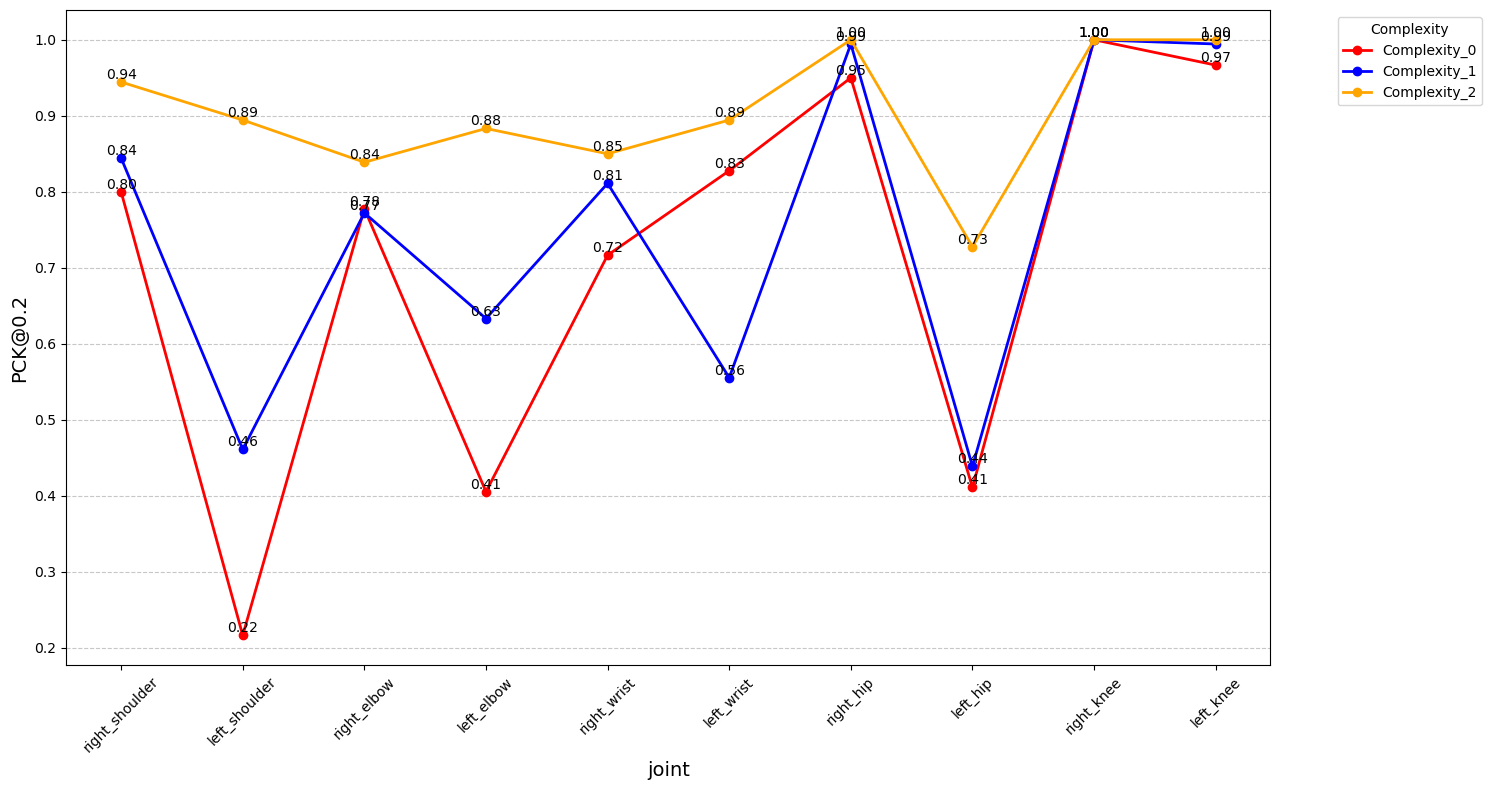

save png : ./data/result/vid1/joint_pck_comparison.png
save json : ./data/result/vid1/pck_results.json


In [208]:
def load_json(file_path):
    """JSON 파일을 읽어 딕셔너리로 반환합니다."""
    with open(file_path, 'r') as f:
        return json.load(f)
    
def save_to_json(data, file_path):
    """데이터를 JSON 파일로 저장합니다."""
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

def extract_keypoints(data, frame_index):
    """주어진 프레임에서 키포인트 좌표를 추출합니다."""
    frame_data = data['annotations'][frame_index]['points']
    keypoints = np.array(frame_data).reshape(-1, 3)[:, :2]  # (x, y) 좌표만 추출
    return keypoints

def calculate_midpoint(point1, point2):
    """두 점의 중점을 계산합니다."""
    return (np.array(point1) + np.array(point2)) / 2

def calculate_torso_length(keypoints):
    """엉덩이와 어깨의 중점 간 거리를 계산합니다."""
    hip_mid = calculate_midpoint(keypoints[7], keypoints[8])  # 좌우 엉덩이
    shoulder_mid = calculate_midpoint(keypoints[1], keypoints[2])  # 좌우 어깨
    return np.linalg.norm(hip_mid - shoulder_mid)

def calculate_joint_pck(gt_keypoints, pred_keypoints, threshold):
    """프레임별 각 관절의 PCK를 계산합니다."""
    return [
        1 if np.linalg.norm(gt_keypoints[i] - pred_keypoints[i]) <= threshold else 0
        for i in range(len(gt_keypoints))
    ]

def process_files(gt_json_path, pred_json_paths):
    """GT와 예측 데이터를 처리해 모든 프레임의 PCK를 계산하고 그래프로 표시합니다."""
    gt_data = load_json(gt_json_path)
    total_frames = len(gt_data['annotations'])
    keypoints = gt_data['categories']['keypoints']  # 모든 관절 포함

    results = []

    # 각 복잡도별 예측 데이터 처리
    for i, pred_path in enumerate(pred_json_paths):
        pred_data = load_json(pred_path)
        joint_pck_sums = np.zeros(len(keypoints))

        for frame_index in range(total_frames):
            gt_keypoints = extract_keypoints(gt_data, frame_index)
            pred_keypoints = extract_keypoints(pred_data, frame_index)

            torso_length = calculate_torso_length(gt_keypoints)
            threshold = 0.2 * torso_length

            joint_pcks = calculate_joint_pck(gt_keypoints, pred_keypoints, threshold)
            joint_pck_sums += np.array(joint_pcks)

        joint_pck_means = joint_pck_sums / total_frames
        results.append({
            'Complexity': f'Complexity_{i}',
            **dict(zip(keypoints, joint_pck_means))
        })

    # 데이터프레임으로 변환
    df = pd.DataFrame(results)

    # 'head' 관절 제거 (시각화에서만)
    joints_to_plot = [k for k in keypoints if k != 'head' and k!="left_ankle" and k!="right_ankle"]

    # 그래프 생성 및 설정
    fig, ax = plt.subplots(figsize=(15, 8))

    colors = ['red', 'blue', 'orange']

    # 각 복잡도별로 꺾은선 그래프 생성
    for idx, row in df.iterrows():
        y_values = [row[joint] for joint in joints_to_plot]
        ax.plot(
            joints_to_plot,  # x축에 표시할 관절 이름들
            y_values,  # 해당 관절의 PCK 값
            marker='o',
            color=colors[idx],  # 복잡도에 따른 색상
            label=row['Complexity'],
            linewidth=2
        )
        
        # 데이터 포인트 위에 값 표시
        for x, y in zip(joints_to_plot, y_values):
            ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('joint', fontsize=14)
    ax.set_ylabel('PCK@0.2', fontsize=14)
    ax.legend(title='Complexity', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./data/result/{last_json_folder}/joint_pck_comparison.png')
    plt.show()
    
    save_to_json(results, f'./data/result/{last_json_folder}/pck_results.json')
    print(f"save png : ./data/result/{last_json_folder}/joint_pck_comparison.png")
    print(f"save json : ./data/result/{last_json_folder}/pck_results.json")

# 파일 경로 설정
gt_json_path = update_gt_output_file
pred_json_paths = mp_output_paths

# PCK 계산 실행
process_files(gt_json_path, pred_json_paths)


여러 json 평균 gt 비교

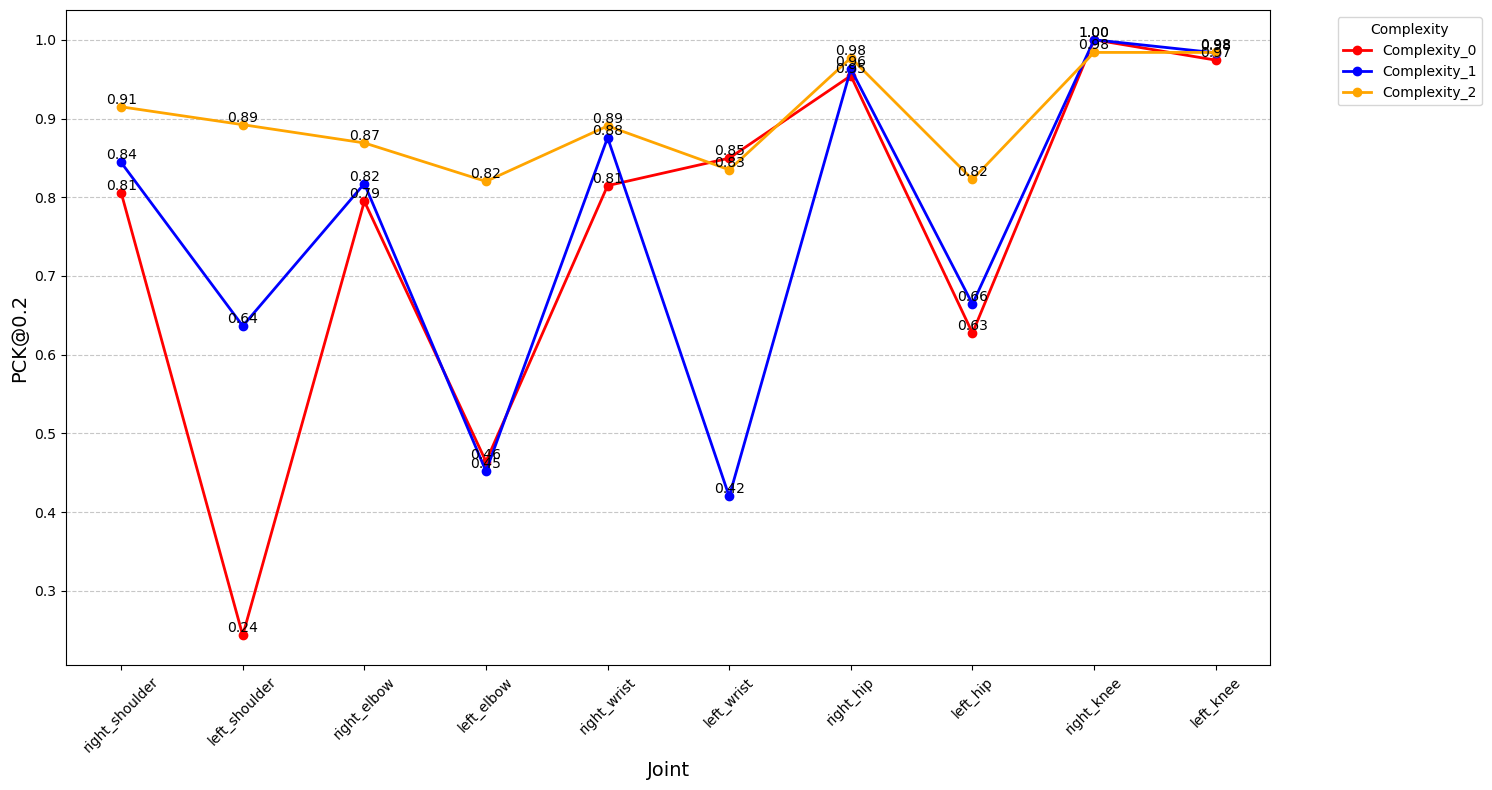

Saved graph as: ./data/result/aggregated_joint_pck_comparison.png


In [209]:
# JSON 파일 로드 함수
def load_json(file_path):
    """JSON 파일을 읽어 딕셔너리로 반환합니다."""
    with open(file_path, 'r') as f:
        return json.load(f)

# PCK 결과를 시각화하는 함수
def plot_pck_results(pck_results_path):
    """JSON 파일에서 PCK 데이터를 로드하고 그래프로 시각화합니다."""
    # JSON 파일 로드
    pck_data = load_json(pck_results_path)

    # Pandas DataFrame으로 변환
    df = pd.DataFrame(pck_data)

    # 'head', 'left_ankle', 'right_ankle' 관절 제거 (시각화에서만)
    joints_to_plot = [
        k for k in df.columns if k not in ['Complexity', 'head', 'left_ankle', 'right_ankle']
    ]

    # 그래프 생성 및 설정
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = ['red', 'blue', 'orange']

    # 각 복잡도별로 꺾은선 그래프 생성
    for idx, row in df.iterrows():
        y_values = [row[joint] for joint in joints_to_plot]
        ax.plot(
            joints_to_plot,  # x축에 표시할 관절 이름들
            y_values,  # 해당 관절의 PCK 값
            marker='o',
            color=colors[idx],  # 복잡도에 따른 색상
            label=row['Complexity'],
            linewidth=2
        )

        # 데이터 포인트 위에 값 표시
        for x, y in zip(joints_to_plot, y_values):
            ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

    # 그래프 레이블 및 설정
    ax.set_xlabel('Joint', fontsize=14)
    ax.set_ylabel('PCK@0.2', fontsize=14)
    ax.legend(title='Complexity', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.xticks(rotation=45)
    plt.tight_layout()

    # 결과 저장
    output_png = pck_results_path.replace("pck_results.json", "joint_pck_comparison.png")
    plt.savefig(output_png)
    plt.show()

    print(f"Saved graph as: {output_png}")

# PCK JSON 파일 경로 설정
pck_results_path = "./data/result/aggregated_pck_results.json"

# 그래프 그리기 실행
plot_pck_results(pck_results_path)